In [9]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from tqdm import tqdm
import random
from collections import deque

In [10]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [11]:
class Actor(nn.Module):

    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)


        self.action_scale = 1.0
        self.action_bias = 0.0

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, -20, 2)  # Prevent numerical instability
        return mean, log_std

    def sample(self, state):

        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)


        x_t = normal.rsample()
        action = torch.tanh(x_t)  # clamping to [-1, 1]


        log_prob = normal.log_prob(x_t)
        log_prob -= torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)

        # Scale action to environment's action space
        action = action * self.action_scale + self.action_bias

        return action, log_prob

In [12]:
class ReplayBuffer:

    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
      self.buffer.append((
          np.asarray(state, dtype=np.float32),
          np.asarray(action, dtype=np.float32),
          float(reward),
          np.asarray(next_state, dtype=np.float32),
          float(done)
      ))


    def sample(self, batch_size):
      batch = random.sample(self.buffer, batch_size)
      states, actions, rewards, next_states, dones = zip(*batch)

      states = torch.from_numpy(np.stack(states).astype(np.float32))
      actions = torch.from_numpy(np.stack(actions).astype(np.float32))
      rewards = torch.from_numpy(np.array(rewards, dtype=np.float32)).unsqueeze(1)
      next_states = torch.from_numpy(np.stack(next_states).astype(np.float32))
      dones = torch.from_numpy(np.array(dones, dtype=np.float32)).unsqueeze(1)

      return states, actions, rewards, next_states, dones


    def __len__(self):
        return len(self.buffer)

In [13]:
class Critic(nn.Module):
   #This is the Q value critic network
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        # Q1 architecture
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

In [14]:
class SAC:
    #Implements soft Actor critic with automatic entropy tuning feature
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dim=256,
        lr_actor=3e-4,
        lr_critic=3e-4,
        lr_alpha=3e-4,
        gamma=0.99,
        tau=0.005,
        alpha=0.2,
        automatic_entropy_tuning=True
    ):
        self.gamma = gamma
        self.tau = tau
        self.automatic_entropy_tuning = automatic_entropy_tuning

        # Actor network
        self.actor = Actor(state_dim, action_dim, hidden_dim)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)


        self.critic1 = Critic(state_dim, action_dim, hidden_dim)
        self.critic2 = Critic(state_dim, action_dim, hidden_dim)
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=lr_critic)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=lr_critic)

        # Target networks for stable learning (avoiding moving targets)
        self.critic1_target = Critic(state_dim, action_dim, hidden_dim)
        self.critic2_target = Critic(state_dim, action_dim, hidden_dim)
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())


        if self.automatic_entropy_tuning:
            self.target_entropy = -action_dim
            self.log_alpha = torch.zeros(1, requires_grad=True)
            self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr_alpha)
            self.alpha = self.log_alpha.exp()
        else:
            self.alpha = alpha

    def select_action(self, state, evaluate=False):
        """Select action from policy"""
        state = torch.FloatTensor(state).unsqueeze(0)
        if evaluate:

            mean, _ = self.actor(state)
            action = torch.tanh(mean)
        else:

            action, _ = self.actor.sample(state)
        return action.detach().cpu().numpy()[0]

    def update(self, replay_buffer, batch_size=256):

        if len(replay_buffer) < batch_size:
            return


        state, action, reward, next_state, done = replay_buffer.sample(batch_size)


        with torch.no_grad():

            next_action, next_log_prob = self.actor.sample(next_state)

            # Compute target Q-values using target networks (take minimum to reduce overestimation)
            target_q1 = self.critic1_target(next_state, next_action)
            target_q2 = self.critic2_target(next_state, next_action)
            target_q = torch.min(target_q1, target_q2)

            # Add entropy term for maximum entropy RL
            target_q = target_q - self.alpha * next_log_prob


            target_q = reward + (1 - done) * self.gamma * target_q      # Finding out  target here


        current_q1 = self.critic1(state, action)
        current_q2 = self.critic2(state, action)


        critic1_loss = F.mse_loss(current_q1, target_q)
        critic2_loss = F.mse_loss(current_q2, target_q)


        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()       #Updating critics networks here


        new_action, log_prob = self.actor.sample(state)


        q1_new = self.critic1(state, new_action)
        q2_new = self.critic2(state, new_action)
        q_new = torch.min(q1_new, q2_new)


        actor_loss = (self.alpha * log_prob - q_new).mean()


        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft entropy tuning implemented , this is what differentiates this algo from normal A2C
        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_prob + self.target_entropy).detach()).mean()

            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()

            self.alpha = self.log_alpha.exp()


        self.soft_update(self.critic1, self.critic1_target)
        self.soft_update(self.critic2, self.critic2_target)

    def soft_update(self, source, target):

        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)     #Soft update: target = tau * source + (1 - tau) * target

In [15]:
def train_sac(
    env_name='MountainCarContinuous-v0',
    num_episodes=500,
    max_steps=1000,
    batch_size=256,
    replay_buffer_size=100000,
    hidden_dim=256,
    lr_actor=3e-4,
    lr_critic=3e-4,
    gamma=0.99,
    tau=0.005,
    start_steps=1000,
    update_every=1,    # Update networks every N steps
    seed=42
):

    env = gym.make(env_name)
    seed_everything(seed)
    env.reset(seed=seed)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]


    agent = SAC(
        state_dim=state_dim,
        action_dim=action_dim,
        hidden_dim=hidden_dim,
        lr_actor=lr_actor,
        lr_critic=lr_critic,
        gamma=gamma,
        tau=tau
    )

    replay_buffer = ReplayBuffer(replay_buffer_size)


    episode_rewards = []
    total_steps = 0

    print(f"Training SAC on {env_name}")
    print(f"State dim: {state_dim}, Action dim: {action_dim}")
    print(f"Hyperparameters: lr_actor={lr_actor}, lr_critic={lr_critic}, gamma={gamma}, tau={tau}")
    print("-" * 60)

    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        episode_reward = 0

        for step in range(max_steps):

            if total_steps < start_steps:
                # Random exploration
                action = env.action_space.sample()
            else:
                # Use policy
                action = agent.select_action(state)


            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated


            replay_buffer.push(state, action, reward, next_state, done)


            if total_steps >= start_steps and total_steps % update_every == 0:
                agent.update(replay_buffer, batch_size)

            state = next_state
            episode_reward += reward
            total_steps += 1

            if done:
                break

        episode_rewards.append(episode_reward)


        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"Episode {episode + 1}/{num_episodes}, Avg Reward (last 50): {avg_reward:.2f}")

    env.close()
    return episode_rewards

Training SAC on MountainCarContinuous-v0
State dim: 2, Action dim: 1
Hyperparameters: lr_actor=0.0003, lr_critic=0.0003, gamma=0.99, tau=0.005
------------------------------------------------------------


 10%|█         | 50/500 [16:26<36:15,  4.83s/it]

Episode 50/500, Avg Reward (last 50): 32.50


 20%|██        | 100/500 [19:52<15:06,  2.27s/it]

Episode 100/500, Avg Reward (last 50): 94.25


 30%|███       | 150/500 [21:44<13:47,  2.36s/it]

Episode 150/500, Avg Reward (last 50): 94.89


 40%|████      | 200/500 [23:39<11:54,  2.38s/it]

Episode 200/500, Avg Reward (last 50): 94.90


 50%|█████     | 250/500 [26:03<12:41,  3.05s/it]

Episode 250/500, Avg Reward (last 50): 93.69


 60%|██████    | 300/500 [28:20<07:58,  2.39s/it]

Episode 300/500, Avg Reward (last 50): 94.15


 70%|███████   | 350/500 [30:20<06:06,  2.44s/it]

Episode 350/500, Avg Reward (last 50): 94.94


 80%|████████  | 400/500 [32:41<05:43,  3.43s/it]

Episode 400/500, Avg Reward (last 50): 94.67


 90%|█████████ | 450/500 [35:18<02:31,  3.03s/it]

Episode 450/500, Avg Reward (last 50): 94.69


100%|██████████| 500/500 [37:37<00:00,  4.51s/it]

Episode 500/500, Avg Reward (last 50): 95.14


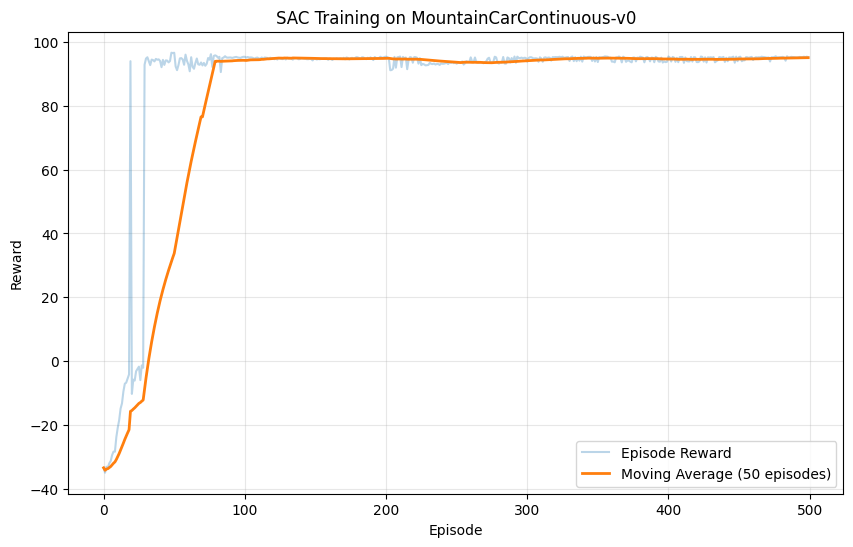


Training completed!
Final average reward (last 50 episodes): 95.14


In [16]:
    rewards = train_sac(
        num_episodes=500,
        lr_actor=3e-4,
        lr_critic=3e-4,
        gamma=0.99,
        tau=0.005,
        hidden_dim=256,
        batch_size=256)

    plt.figure(figsize=(10, 6))
    plt.plot(rewards, alpha=0.3, label='Episode Reward')

    # Plot moving average
    window = 50
    if len(rewards) >= window:
        moving_avg = [np.mean(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
        plt.plot(moving_avg, label=f'Moving Average ({window} episodes)', linewidth=2)

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('SAC Training on MountainCarContinuous-v0')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


    print(f"Final average reward (last 50 episodes): {np.mean(rewards[-50:]):.2f}")